In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nielmirafuentes_exp_dataset_path = kagglehub.dataset_download('nielmirafuentes/exp-dataset')

print('Data source import complete.')
nielmirafuentes_exp_dataset_path = f"{nielmirafuentes_exp_dataset_path}/ChatGPT_Rationales_file_REDDIT_dataset(90-10).csv"

100%|██████████| 2.78M/2.78M [00:01<00:00, 2.42MB/s]

Extracting files...


Data source import complete.


In [ ]:
!pip install -q transformers datasets evaluate tensorflow tensorflow_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
import os
import gc
import re
import math
import random
from typing import List, Tuple
from collections import defaultdict
from sklearn.model_selection import train_test_split
import argparse


import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_recall_fscore_support,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    jaccard_score,
    roc_auc_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow_hub as hub


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, get_linear_schedule_with_warmup
from torch.optim import AdamW
from typing import Optional, Tuple, List, Dict

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
class TemporalCNN(nn.Module):
    """
    Temporal CNN applied across the sequence (time) dimension.
    Input: sequence_embeddings (B, L, H), attention_mask (B, L)
    Output: pooled vector (B, output_dim) where output_dim = num_filters * len(kernel_sizes) * 2
            (we concatenate max-pooled and mean-pooled features for each kernel size)
    """
    def __init__(self, input_dim=768, num_filters=256, kernel_sizes=(2,3,4), dropout=0.3):
        super().__init__()
        self.input_dim = input_dim
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes

        # Convs expect (B, C_in, L) where C_in = input_dim
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=input_dim, out_channels=num_filters, kernel_size=k, padding=k//2)
            for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, sequence_embeddings, attention_mask=None):
        """
        sequence_embeddings: (B, L, H)
        attention_mask: (B, L) with 1 for valid tokens, 0 for padding
        returns: (B, num_filters * len(kernel_sizes) * 2)  # max + mean pooled per conv
        """
        # transpose to (B, H, L)
        x = sequence_embeddings.transpose(1, 2).contiguous()  # (B, H, L)

        pooled_outputs = []
        for conv in self.convs:
            conv_out = conv(x)                # (B, num_filters, L_out)
            conv_out = F.relu(conv_out)
            L_out = conv_out.size(2)

            if attention_mask is not None:
                # resize mask to match L_out
                mask = attention_mask.float()
                if mask.size(1) != L_out:
                    mask = F.interpolate(mask.unsqueeze(1), size=L_out, mode='nearest').squeeze(1)
                mask = mask.unsqueeze(1).to(conv_out.device)  # (B,1,L_out)

                # max pool with masking
                neg_inf = torch.finfo(conv_out.dtype).min / 2
                max_masked = torch.where(mask.bool(), conv_out, neg_inf*torch.ones_like(conv_out))
                max_pooled = torch.max(max_masked, dim=2)[0]  # (B, num_filters)

                # mean pool with masking
                sum_masked = (conv_out * mask).sum(dim=2)    # (B, num_filters)
                denom = mask.sum(dim=2).clamp_min(1e-6)     # (B,1)
                mean_pooled = sum_masked / denom            # (B, num_filters)
            else:
                max_pooled = torch.max(conv_out, dim=2)[0]
                mean_pooled = conv_out.mean(dim=2)

            pooled_outputs.append(max_pooled)
            pooled_outputs.append(mean_pooled)

        out = torch.cat(pooled_outputs, dim=1)  # (B, num_filters * len(kernel_sizes) * 2)
        out = self.dropout(out)
        return out

In [ ]:
def visualize_rationales(tokenizer, input_ids_batch, attention_mask_batch, rationale_scores_batch,
                         labels_true=None, labels_pred=None, probs=None, n_samples=5):
    """
    Print token-level rationale scores for the first few test samples.
    """
    for i in range(min(n_samples, len(input_ids_batch))):
        input_ids = input_ids_batch[i]
        attn_mask = attention_mask_batch[i]
        scores = rationale_scores_batch[i]

        tokens = tokenizer.convert_ids_to_tokens(input_ids[attn_mask.bool()])
        scores = scores[attn_mask.bool()]

        prob_str = f"{probs[i]:.3f}" if probs is not None else "N/A"
        true_label = labels_true[i] if labels_true is not None else "?"
        pred_label = labels_pred[i] if labels_pred is not None else "?"

        print(f"Sample {i} | True: {true_label} | Pred: {pred_label} | Prob: {prob_str}")
        for tok, score in zip(tokens, scores):
            if isinstance(score, torch.Tensor):
                score = score.item()
            print(f"{tok:<15} : {score:.3f}")
        print()

In [ ]:
class MultiScaleAttentionCNN(nn.Module):
    def __init__(self, hidden_size=768, num_filters=64,
                 kernel_sizes=(2,3,4,5,6,7), dropout=0.3):
        super().__init__()

        self.hidden_size = hidden_size
        self.kernel_sizes = kernel_sizes

        self.convs = nn.ModuleList()
        self.pads  = nn.ModuleList()

        for k in self.kernel_sizes:
            # compute correct SAME padding
            pad_left  = (k - 1) // 2
            pad_right = k - 1 - pad_left

            # asymmetric padding
            self.pads.append(nn.ConstantPad1d((pad_left, pad_right), 0.0))

            # conv with no padding (padding=0)
            self.convs.append(
                nn.Conv1d(hidden_size, num_filters, kernel_size=k, padding=0)
            )

        self.attn = nn.ModuleList([nn.Linear(num_filters, 1) for _ in self.kernel_sizes])
        self.output_size = num_filters * len(self.kernel_sizes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, hidden_states, mask):
        """
        hidden_states: (B, L, H)
        mask:          (B, L)
        """
        x = hidden_states.transpose(1, 2)  # (B, H, L)
        attn_mask = mask.unsqueeze(1).float()

        conv_outs = []

        for pad, conv, att in zip(self.pads, self.convs, self.attn):
            padded = pad(x)      # (B, H, L) EXACT SAME LENGTH as input
            c = conv(padded)     # (B, F, L)
            c = F.relu(c)
            c = c * attn_mask

            c_t = c.transpose(1, 2)    # (B, L, F)
            w = att(c_t)               # (B, L, 1)
            w = w.masked_fill(mask.unsqueeze(-1) == 0, -1e9)
            w = F.softmax(w, dim=1)

            pooled = (c_t * w).sum(dim=1)   # (B, F)
            conv_outs.append(pooled)

        out = torch.cat(conv_outs, dim=1)   # (B, F * K)
        return self.dropout(out)

In [ ]:
class AdditionalCustomDataset(Dataset):
    def __init__(self, texts, labels, rationales, tokenizer, bert_tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.rationales = rationales
        self.tokenizer = tokenizer            # tokenizer for HateBERT (original text)
        self.bert_tokenizer = bert_tokenizer  # tokenizer for rationale text
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        rationale_text = str(self.rationales[idx]) if (self.rationales is not None) else ""
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            return_attention_mask=True
        )
        add_enc = self.bert_tokenizer(
            rationale_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            return_attention_mask=True
        )

        input_ids = enc['input_ids'].squeeze(0)
        attention_mask = enc['attention_mask'].squeeze(0)
        additional_input_ids = add_enc['input_ids'].squeeze(0)
        additional_attention_mask = add_enc['attention_mask'].squeeze(0)

        # Build token-level rationale mask by token-string overlap
        orig_tokens = self.tokenizer.convert_ids_to_tokens(input_ids.tolist())
        rat_tokens = set([t for t in self.bert_tokenizer.convert_ids_to_tokens(additional_input_ids.tolist()) if t not in (self.bert_tokenizer.pad_token, None)])
        rationale_mask = torch.zeros(self.max_length, dtype=torch.float)
        for i, tok in enumerate(orig_tokens):
            if i >= self.max_length:
                break
            if tok in rat_tokens and tok not in (self.tokenizer.pad_token, None):
                rationale_mask[i] = 1.0

        # ensure we don't mark PAD positions
        pad_id = self.tokenizer.pad_token_id
        if pad_id is not None:
            pad_positions = (input_ids == pad_id).nonzero(as_tuple=True)[0]
            for p in pad_positions:
                rationale_mask[p] = 0.0

        return input_ids, attention_mask, additional_input_ids, additional_attention_mask, torch.tensor(label, dtype=torch.long), rationale_mask

In [ ]:
class ProjectionMLP(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_labels=2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_labels)
        )
    def forward(self, x):
        return self.layers(x)

In [ ]:
class ConcatModelWithRationale(nn.Module):
    def __init__(self,
                 hatebert_model,
                 additional_model,
                 projection_mlp,
                 hidden_size=768,
                 gumbel_temp=0.5,
                 freeze_additional_model=True,
                 cnn_num_filters=64,
                 cnn_kernel_sizes=(2,3,4,5,6,7),
                 cnn_dropout=0.0):
        super().__init__()
        self.hatebert_model = hatebert_model
        self.additional_model = additional_model
        self.projection_mlp = projection_mlp
        self.gumbel_temp = gumbel_temp
        self.hidden_size = hidden_size

        # freeze additional_model if requested
        if freeze_additional_model:
            for param in self.additional_model.parameters():
                param.requires_grad = False

        # selector head (per-token logits)
        self.selector = nn.Linear(hidden_size, 1)

        # Temporal CNN over HateBERT embeddings (main text)
        self.temporal_cnn = TemporalCNN(input_dim=hidden_size,
                                        num_filters=cnn_num_filters,
                                        kernel_sizes=cnn_kernel_sizes,
                                        dropout=cnn_dropout)
        self.temporal_out_dim = cnn_num_filters * len(cnn_kernel_sizes) * 2

        # MultiScaleAttentionCNN over rationale embeddings (frozen BERT)
        self.msa_cnn = MultiScaleAttentionCNN(hidden_size=hidden_size,
                                              num_filters=cnn_num_filters,
                                              kernel_sizes=cnn_kernel_sizes,
                                              dropout=cnn_dropout)
        self.msa_out_dim = self.msa_cnn.output_size

    def gumbel_sigmoid_sample(self, logits):
        noise = -torch.log(-torch.log(torch.rand_like(logits) + 1e-9) + 1e-9)
        y = logits + noise
        return torch.sigmoid(y / self.gumbel_temp)

    def forward(self, input_ids, attention_mask, additional_input_ids, additional_attention_mask, return_attentions=False):
        # Main text through HateBERT
        hatebert_out = self.hatebert_model(input_ids=input_ids,
                                           attention_mask=attention_mask,
                                           output_attentions=return_attentions,
                                           return_dict=True)
        hatebert_emb = hatebert_out.last_hidden_state   # (B, L, H)
        cls_emb = hatebert_emb[:, 0, :]                 # (B, H)

        # Rationale text through frozen BERT
        with torch.no_grad():
            add_out = self.additional_model(input_ids=additional_input_ids,
                                            attention_mask=additional_attention_mask,
                                            return_dict=True)
            rationale_emb = add_out.last_hidden_state   # (B, L, H)

        # selector logits & Gumbel-Sigmoid sampling on HateBERT
        selector_logits = self.selector(hatebert_emb).squeeze(-1)  # (B, L)
        rationale_probs = self.gumbel_sigmoid_sample(selector_logits)  # (B, L)
        rationale_probs = rationale_probs * attention_mask.float().to(rationale_probs.device)

        # pooled rationale summary
        masked_hidden = hatebert_emb * rationale_probs.unsqueeze(-1)
        denom = rationale_probs.sum(1).unsqueeze(-1).clamp_min(1e-6)
        pooled_rationale = masked_hidden.sum(1) / denom  # (B, H)

        # CNN branches
        temporal_features = self.temporal_cnn(hatebert_emb, attention_mask)           # (B, temporal_out_dim)
        rationale_features = self.msa_cnn(rationale_emb, additional_attention_mask)   # (B, msa_out_dim)

        # concat CLS + CNN features + pooled rationale
        concat_emb = torch.cat((cls_emb, temporal_features, rationale_features, pooled_rationale), dim=1)

        logits = self.projection_mlp(concat_emb)

        attns = hatebert_out.attentions if (return_attentions and hasattr(hatebert_out, "attentions")) else None
        return logits, rationale_probs, selector_logits, attns

In [ ]:
def combined_loss(logits, labels, rationale_probs, selector_logits, rationale_mask=None, attns=None, attn_weight=0.0, rationale_weight=1.0):
    cls_loss = F.cross_entropy(logits, labels)

    # supervise selector logits with BCE-with-logits against rationale mask (if available)
    if rationale_mask is not None:
        selector_loss = F.binary_cross_entropy_with_logits(selector_logits, rationale_mask.to(selector_logits.device))
    else:
        selector_loss = torch.tensor(0.0, device=cls_loss.device)

    # optional attention alignment loss (disabled by default)
    attn_loss = torch.tensor(0.0, device=cls_loss.device)
    if attns is not None and attn_weight > 0.0:
        try:
            last_attn = attns[-1]  # (B, H, L, L)
            attn_mass = last_attn.mean(1).mean(1)  # (B, L)
            attn_loss = F.mse_loss(attn_mass, rationale_mask.to(attn_mass.device))
        except Exception:
            attn_loss = torch.tensor(0.0, device=cls_loss.device)

    total_loss = cls_loss + rationale_weight * selector_loss + attn_weight * attn_loss
    return total_loss, cls_loss.item(), selector_loss.item(), attn_loss.item()

In [ ]:
import matplotlib.pyplot as plt

def plot_two_arrays(arr1, arr2, label1, label2, title="My Plot"):
    plt.figure(figsize=(8, 4))

    plt.plot(arr1, label=label1, color='red')
    plt.plot(arr2, label=label2, color='blue')

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
class EarlyStopping:
    """
    Early stopping to stop training when validation loss doesn't improve.
    """
    def __init__(self, patience=10, min_delta=1.0, mode='max', verbose=True):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            min_delta (float): Minimum change to qualify as an improvement.
            mode (str): 'min' for loss, 'max' for accuracy/f1.
            verbose (bool): Print messages when improvement occurs.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, current_score, model):
        """
        Call this after each epoch with the validation metric and model.

        Args:
            current_score: Current epoch's validation metric (loss, accuracy, f1, etc.)
            model: The model to save if there's improvement

        Returns:
            bool: True if training should stop, False otherwise
        """
        if self.best_score is None:
            # First epoch
            self.best_score = current_score
            self.save_checkpoint(model)
            if self.verbose:
                print(f"Initial best score: {self.best_score:.4f}")
        else:
            # Check if there's improvement
            if self.mode == 'min':
                improved = current_score < (self.best_score - self.min_delta)
            else:  # mode == 'max'
                improved = current_score > (self.best_score + self.min_delta)

            if improved:
                self.best_score = current_score
                self.save_checkpoint(model)
                self.counter = 0
                if self.verbose:
                    print(f"Validation improved! New best score: {self.best_score:.4f}")
            else:
                self.counter += 1
                if self.verbose:
                    print(f"No improvement. Patience counter: {self.counter}/{self.patience}")

                if self.counter >= self.patience:
                    self.early_stop = True
                    if self.verbose:
                        print(f"Early stopping triggered! Best score: {self.best_score:.4f}")

        return self.early_stop

    def save_checkpoint(self, model):
        """Save model state dict"""
        import copy
        self.best_model_state = copy.deepcopy(model.state_dict())

    def load_best_model(self, model):
        """Load the best model state into the model"""
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)
            if self.verbose:
                print(f"Loaded best model with score: {self.best_score:.4f}")
        return model

In [ ]:
def train_and_evaluate(reddit_csv_path,
                       hatebert_model,
                       rationale_model,
                       tokenizer_hatebert,
                       tokenizer_rationale,
                       epochs=100,
                       batch_size=16,
                       lr=3e-5,
                       seed=42,
                       max_length=128,
                       freeze_rationale=True,
                       cnn_num_filters=128,
                       cnn_kernel_sizes=(2,3,4),
                       cnn_dropout=0.3,
                       adapter_dim=128,
                       classifier_type="multihead",
                       show_visualizations=5,
                       weight_decay=0.05,
                       device=None,
                        use_early_stopping=True, patience=3,
                       early_stop_metric='loss', min_delta=0.001):
    """
    Train and evaluate the ConcatModelWithRationale pipeline on a dataset CSV.
    """
    set_seed(seed)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # Load dataset
    df = pd.read_csv(reddit_csv_path)
    train_df = df[df['exp_split'] == 'train'].reset_index(drop=True)
    test_df = df[df['exp_split'] == 'test'].reset_index(drop=True)

    print("Train df:", len(train_df))
    print("Test df:", len(test_df))

    # Extract texts, labels, and rationales
    train_texts = train_df['text'].tolist()
    train_labels = train_df['label'].tolist()
    train_rationales = train_df['ChatGPT_Rationales'].tolist() if 'ChatGPT_Rationales' in train_df.columns else [""]*len(train_df)

    test_texts = test_df['text'].tolist()
    test_labels = test_df['label'].tolist()
    test_rationales = test_df['ChatGPT_Rationales'].tolist() if 'ChatGPT_Rationales' in test_df.columns else [""]*len(test_df)

    # Optional: create validation set from training data (e.g., 10% of train)
    val_size = int(0.2 * len(train_texts))
    val_texts = train_texts[:val_size]
    val_labels = train_labels[:val_size]
    val_rationales = train_rationales[:val_size]

    tr_texts = train_texts[val_size:]
    tr_labels = train_labels[val_size:]
    tr_rationales = train_rationales[val_size:]

    # Datasets and DataLoaders
    train_dataset = AdditionalCustomDataset(tr_texts, tr_labels, tr_rationales,
                                            tokenizer_hatebert, tokenizer_rationale, max_length)
    val_dataset = AdditionalCustomDataset(val_texts, val_labels, val_rationales,
                                          tokenizer_hatebert, tokenizer_rationale, max_length)
    test_dataset = AdditionalCustomDataset(test_texts, test_labels, test_rationales,
                                           tokenizer_hatebert, tokenizer_rationale, max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Model
    H = hatebert_model.config.hidden_size
    dummy_hatebert = torch.zeros(1, max_length, H)
    dummy_rationale = torch.zeros(1, max_length, H)

    # TemporalCNN over HateBERT embeddings
    dummy_temporal = TemporalCNN(input_dim=H, num_filters=cnn_num_filters, kernel_sizes=cnn_kernel_sizes, dropout=cnn_dropout)
    temporal_out_dim = dummy_temporal(dummy_hatebert).shape[1]

    # MultiScaleAttentionCNN over rationale embeddings
    dummy_msa = MultiScaleAttentionCNN(hidden_size=H, num_filters=cnn_num_filters, kernel_sizes=cnn_kernel_sizes, dropout=cnn_dropout)
    msa_out_dim = dummy_msa(dummy_rationale, mask=torch.ones(1, max_length)).shape[1]

    # Projection MLP input dimension: CLS + TemporalCNN + MSA + pooled rationale
    proj_input_dim = H + temporal_out_dim + msa_out_dim + H

    projection_mlp = ProjectionMLP(input_size=proj_input_dim, hidden_size=adapter_dim, num_labels=len(set(train_labels)))

    model = ConcatModelWithRationale(
        hatebert_model=hatebert_model,
        additional_model=rationale_model,
        projection_mlp=projection_mlp,
        hidden_size=H,
        freeze_additional_model=freeze_rationale,
        cnn_num_filters=cnn_num_filters,
        cnn_kernel_sizes=cnn_kernel_sizes,
        cnn_dropout=cnn_dropout
    ).to(device)

    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    if use_early_stopping:
        mode = 'min' if early_stop_metric == 'loss' else 'max'
        print(f"early stopping mode: {mode} on {early_stop_metric}")
        early_stopping = EarlyStopping(patience=patience, min_delta=min_delta,
                                      mode=mode, verbose=True)
        print(f"\nEarly stopping enabled: monitoring validation {early_stop_metric} "
              f"with patience={patience}, min_delta={min_delta}")

    train_loss = []
    val_loss = []

    val_precision = []
    val_accuracy = []
    val_f1=[]
    val_recall=[]

    train_f1 = []
    train_recall = []
    train_precision = []
    train_accuracy = []


    # Training
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_samples = 0
        correct = 0
        preds_arr,trues_arr = [] , []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids, attention_mask, add_input_ids, add_att_mask, labels, rat_mask = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            add_input_ids = add_input_ids.to(device)
            add_att_mask = add_att_mask.to(device)
            labels = labels.to(device)
            rat_mask = rat_mask.to(device)

            optimizer.zero_grad()
            logits, rationale_probs, selector_logits, _ = model(input_ids, attention_mask, add_input_ids, add_att_mask)
            loss, cls_loss, sel_loss, _ = combined_loss(logits, labels, rationale_probs, selector_logits, rationale_mask=rat_mask)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            total_samples += labels.size(0)
            correct += (preds == labels).sum().item()
            preds_arr.extend(preds.cpu().numpy().tolist())
            trues_arr.extend(labels.cpu().numpy().tolist())


        accuracy = accuracy_score(y_true=trues_arr, y_pred=preds_arr)
        precision = precision_score(y_true=trues_arr, y_pred=preds_arr)
        f1 = f1_score(y_true=trues_arr, y_pred=preds_arr)
        recall = recall_score(y_true=trues_arr, y_pred=preds_arr)
        epoch_train_loss = total_loss/len(train_loader)



        train_loss.append(epoch_train_loss)
        train_accuracy.append(accuracy)
        train_precision.append(precision)
        train_recall.append(recall)
        train_f1.append(f1)


        print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f} Accuracy={accuracy:.4f} Precision={precision:.4f} f1 score={f1:.4f} recall={recall:.4f}")

        # Validation
        model.eval()
        val_preds, val_labels_list = [], []
        validation_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, add_input_ids, add_att_mask, labels, rat_mask = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                add_input_ids = add_input_ids.to(device)
                add_att_mask = add_att_mask.to(device)
                labels = labels.to(device)
                rat_mask = rat_mask.to(device)

                logits, rationale_probs, selector_logits, _ = model(input_ids, attention_mask, add_input_ids, add_att_mask)
                loss, _, _, _ = combined_loss(logits, labels, rationale_probs, selector_logits, rationale_mask=rat_mask)
                validation_loss += loss.item()
                preds = logits.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels_list.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels_list, val_preds)
        val_prec = precision_score(y_true=val_labels_list, y_pred=val_preds)
        val_f1_score = f1_score(y_true=val_labels_list, y_pred=val_preds)
        val_rec = recall_score(y_true=val_labels_list, y_pred=val_preds)
        epoch_val_loss = validation_loss /len(val_loader)

        val_loss.append(epoch_val_loss)
        val_accuracy.append(val_acc)
        val_precision.append(val_prec)
        val_f1.append(val_f1_score)
        val_recall.append(val_rec)
        print(f"Validation Accuracy: {val_acc:.4f} Precision: {val_prec} f1: {val_f1_score} recall: {val_rec} loss: {epoch_val_loss}")
        if use_early_stopping:
            if early_stop_metric == 'loss':
                current_metric = epoch_val_loss
            elif early_stop_metric == 'accuracy':
                current_metric = val_acc
            elif early_stop_metric == 'f1':
                current_metric = val_f1_score
            elif early_stop_metric == 'precision':
                current_metric = val_prec
            elif early_stop_metric == 'recall':
                current_metric = val_rec
            else:
                raise ValueError(f"Unknown metric: {early_stop_metric}")

        if early_stopping(current_metric, model):
                print(f"\n{'='*50}")
                print(f"Early stopping at epoch {epoch+1}")
                print(f"{'='*50}\n")
                break
    if use_early_stopping:
        model = early_stopping.load_best_model(model)


    # Test
    model.eval()
    test_preds, test_labels_list = [], []
    saved_rationales = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, add_input_ids, add_att_mask, labels, _ = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            add_input_ids = add_input_ids.to(device)
            add_att_mask = add_att_mask.to(device)
            labels = labels.to(device)

            logits, rationale_probs, _, _ = model(input_ids, attention_mask, add_input_ids, add_att_mask)
            probs = logits.softmax(dim=1)
            preds = logits.argmax(dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels_list.extend(labels.cpu().numpy())

            # Save a few rationales for visualization
            if len(saved_rationales) < show_visualizations:
                for i in range(input_ids.size(0)):
                    if len(saved_rationales) >= show_visualizations:
                        break
                    saved_rationales.append((
                        input_ids[i].cpu().unsqueeze(0),
                        attention_mask[i].cpu().unsqueeze(0),
                        rationale_probs[i].cpu().unsqueeze(0),
                        labels[i].item(),
                        preds[i].item(),
                        probs[i, preds[i].item()].item()
                    ))
    plot_two_arrays(train_loss, val_loss, "train loss", "validation loss", "loss over epochs")
    plot_two_arrays(train_accuracy, val_accuracy, "train accuracy", "validation accuracy", "accuracy over epoch")
    plot_two_arrays(train_precision, val_precision, "train precision", "validation precision", "precision over epoch")
    plot_two_arrays(train_f1, val_f1, "train f1", "validation f1", "f1 over epoch")
    plot_two_arrays(train_recall, val_recall, "train recall", "validation recall", "recall over epoch")

    # Metrics
    print(f"train loss: {train_loss}")
    print(f"validation loss: {val_loss}")
    acc = accuracy_score(test_labels_list, test_preds)
    print(f"\n=== Test Accuracy: {acc:.4f} ===")
    print(classification_report(test_labels_list, test_preds, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(test_labels_list, test_preds))

    # Visualize first few rationales
    print("\n=== Rationale visualization ===")

    input_ids_batch = [inp_ids for inp_ids, *_ in saved_rationales]
    attn_mask_batch = [attn_mask for _, attn_mask, *_ in saved_rationales]
    scores_batch = [scores for _, _, scores, *_ in saved_rationales]
    labels_true = [true for *_, true, _, _ in saved_rationales]
    labels_pred = [pred for *_, _, pred, _ in saved_rationales]
    pred_prob = [prob for *_, prob in saved_rationales]

    visualize_rationales(
        tokenizer=tokenizer_hatebert,
        input_ids_batch=input_ids_batch,
        attention_mask_batch=attn_mask_batch,
        rationale_scores_batch=scores_batch,
        labels_true=labels_true,
        labels_pred=labels_pred,
        probs=pred_prob,
        n_samples=len(saved_rationales)
    )

    return model, max(val_accuracy), min(val_loss)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/151 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device: cuda
Train df: 33447
Test df: 3717
early stopping mode: min on loss

Early stopping enabled: monitoring validation loss with patience=3, min_delta=0.001


Epoch 1/100: 100%|██████████| 3345/3345 [15:34<00:00,  3.58it/s]

Epoch 1: Train Loss=0.4843 Accuracy=0.8463 Precision=0.8086 f1 score=0.7873 recall=0.7672


Validation Accuracy: 0.8959 Precision: 0.8513459220570511 f1: 0.8589379813538711 recall: 0.8666666666666667 loss: 0.4086721522005869
Initial best score: 0.4087


Epoch 2/100: 100%|██████████| 3345/3345 [15:22<00:00,  3.63it/s]


Epoch 2: Train Loss=0.3211 Accuracy=0.9382 Precision=0.9129 f1 score=0.9171 recall=0.9213
Validation Accuracy: 0.9291 Precision: 0.896579476861167 f1: 0.9038539553752536 recall: 0.9112474437627812 loss: 0.4140011206482901
No improvement. Patience counter: 1/3


Epoch 3/100: 100%|██████████| 3345/3345 [15:22<00:00,  3.63it/s]

Epoch 3: Train Loss=0.2229 Accuracy=0.9696 Precision=0.9580 f1 score=0.9590 recall=0.9601


Validation Accuracy: 0.9406 Precision: 0.9 f1: 0.9206793206793207 recall: 0.9423312883435583 loss: 0.41302798656032397
No improvement. Patience counter: 2/3


Epoch 4/100: 100%|██████████| 3345/3345 [15:20<00:00,  3.64it/s]

Epoch 4: Train Loss=0.1612 Accuracy=0.9838 Precision=0.9780 f1 score=0.9782 recall=0.9784


Validation Accuracy: 0.9483 Precision: 0.9292433537832311 f1: 0.9292433537832311 recall: 0.9292433537832311 loss: 0.4532894002754361
No improvement. Patience counter: 3/3
Early stopping triggered! Best score: 0.4087

Early stopping at epoch 4

Loaded best model with score: 0.4087


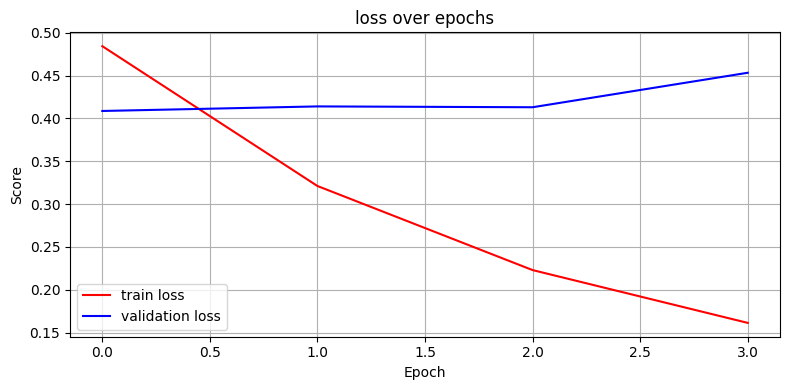

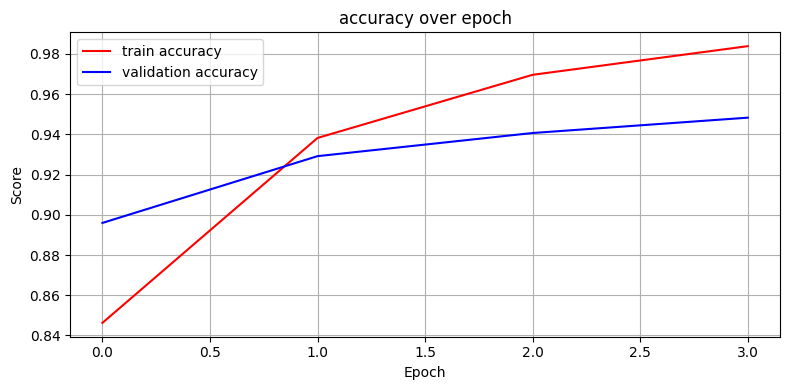

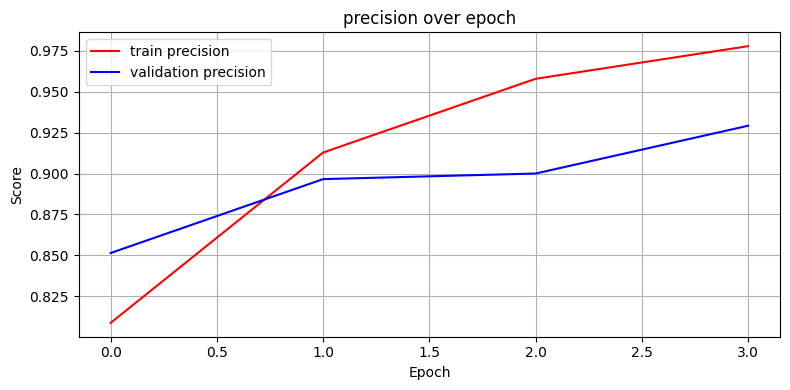

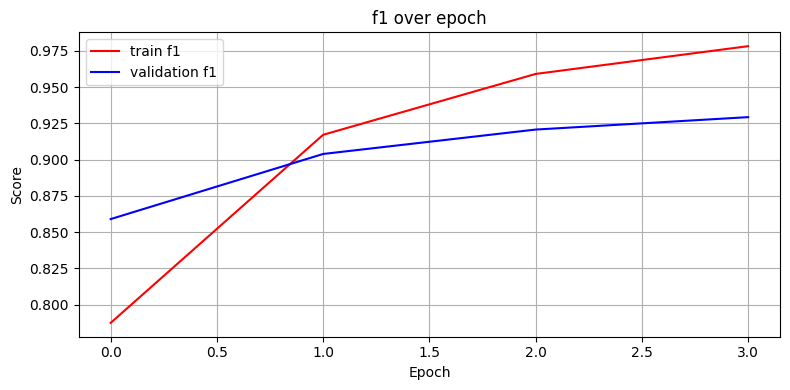

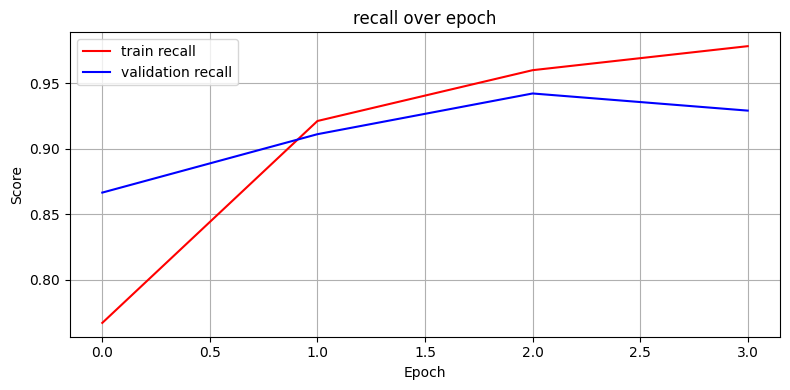

train loss: [0.48434361931721726, 0.3210661006492795, 0.2228909142955759, 0.1612357013999458]
validation loss: [0.4086721522005869, 0.4140011206482901, 0.41302798656032397, 0.4532894002754361]

=== Test Accuracy: 0.9013 ===
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2342
           1       0.87      0.86      0.87      1375

    accuracy                           0.90      3717
   macro avg       0.89      0.89      0.89      3717
weighted avg       0.90      0.90      0.90      3717

Confusion Matrix:
 [[2165  177]
 [ 190 1185]]

=== Rationale visualization ===
Sample 0 | True: 1 | Pred: 1 | Prob: 0.948
[CLS]           : 0.999
put             : 1.000
them            : 0.174
all             : 0.745
in              : 0.721
the             : 0.926
same            : 0.975
cramped         : 0.574
jail            : 0.748
cell            : 0.805
with            : 0.771
no              : 0.932
soap            : 0.998
tooth          

In [ ]:
if __name__ == "__main__":
    import argparse
    from transformers import AutoModel, AutoTokenizer

    parser = argparse.ArgumentParser()
    parser.add_argument("--reddit_csv", type=str,
                        default=nielmirafuentes_exp_dataset_path)
    parser.add_argument("--epochs", type=int, default=2)
    parser.add_argument("--batch_size", type=int, default=8)
    parser.add_argument("--freeze_additional", choices=["yes","no"], default="yes")
    parser.add_argument("--max_length", type=int, default=128)
    parser.add_argument("--lr", type=float, default=1e-5)
    parser.add_argument("--show_visualizations", type=int, default=5)
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--cnn_filters", type=int, default=128)
    parser.add_argument("--cnn_dropout", type=float, default=0.4)
    parser.add_argument("--cnn_kernels", nargs='+', type=int, default=[2,3,4,5,6,7])
    parser.add_argument("--hatebert_model_name", type=str, default="GroNLP/HateBERT")
    parser.add_argument("--rationale_model_name", type=str, default="bert-base-uncased")

    args, _ = parser.parse_known_args()

    # Load models and tokenizers
    hatebert_model = AutoModel.from_pretrained(args.hatebert_model_name)
    rationale_model = AutoModel.from_pretrained(args.rationale_model_name)
    tokenizer_hatebert = AutoTokenizer.from_pretrained(args.hatebert_model_name)
    tokenizer_rationale = AutoTokenizer.from_pretrained(args.rationale_model_name)

    learning_rate = 9.30630808529575e-06
    batch_size = 8
    weight_decay = 0.094911774740447

    # Train and evaluate
    model, acc, loss = train_and_evaluate(
        reddit_csv_path=args.reddit_csv,
        hatebert_model=hatebert_model,
        rationale_model=rationale_model,
        tokenizer_hatebert=tokenizer_hatebert,
        tokenizer_rationale=tokenizer_rationale,
        epochs=100,
        batch_size=batch_size,
        freeze_rationale=(args.freeze_additional.lower() == "yes"),
        max_length=args.max_length,
        lr=learning_rate,
        show_visualizations=args.show_visualizations,
        seed=args.seed,
        cnn_num_filters=args.cnn_filters,
        cnn_kernel_sizes=tuple(args.cnn_kernels),
        cnn_dropout=args.cnn_dropout,
        weight_decay=weight_decay
    )
    print(f"Acc: {acc} ------ Loss: {loss}")
